In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
dfc = pd.read_json("../sources/florida/data/data.json.gz")
dfc = dfc.drop(["edvisit","county","age_group","chartdate","case"],axis=1, errors="ignore")
dfc = dfc.rename({"case_":"case"},axis=1)

dfc["died"] = dfc["died"].map({"Yes":True,"NA":False}).fillna(False)
dfc = dfc[dfc["age"] != "NA"]
dfc = dfc[dfc["gender"] != "Unknown"]
dfc["gender"] = dfc["gender"].str[0]
dfc["age"] = dfc["age"].astype(int)
for k in ["case","eventdate"]:
#     dfc[k] = pd.to_datetime(dfc[k].str.split(" ",1).str[0])
    dfc[k] = pd.to_datetime(dfc[k], unit="ms")
dfc["known_status"] = (dfc["hospitalized"]=="YES") | (dfc["hospitalized"]=="NO")

# data entry error, off by a year
# dfc.loc[dfc["eventdate"] < pd.Timestamp("2019-11-01"), "eventdate"] += pd.Timedelta("1y")

dfc.head()

,age,case,died,eventdate,gender,hospitalized,known_status
0,63,2020-03-02 05:00:00,False,2020-02-22,M,YES,True
1,29,2020-03-02 05:00:00,False,2020-02-22,F,NO,True
2,22,2020-03-03 05:00:00,False,2020-02-25,F,NO,True
3,54,2020-03-03 05:00:00,False,2020-02-02,M,UNKNOWN,False
4,59,2020-03-04 05:00:00,False,2020-02-15,F,YES,True


In [8]:
dfc["died"].value_counts()

False    31895
True      1240
Name: died, dtype: int64

In [9]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33135 entries, 0 to 33192
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   age           33135 non-null  int64         
 1   case          33135 non-null  datetime64[ns]
 2   died          33135 non-null  bool          
 3   eventdate     33135 non-null  datetime64[ns]
 4   gender        33135 non-null  object        
 5   hospitalized  33135 non-null  object        
 6   known_status  33135 non-null  bool          
dtypes: bool(2), datetime64[ns](2), int64(1), object(2)
memory usage: 1.6+ MB


In [10]:
dfc["gender"].value_counts()

M    16591
F    16544
Name: gender, dtype: int64

In [11]:
dfc["hospitalized"].value_counts()

NO         16910
UNKNOWN    10305
YES         5624
NA           296
Name: hospitalized, dtype: int64

In [12]:
from yahist import Hist1D
from yahist.utils import set_default_style
set_default_style()

In [13]:
dfc["age"].isna().sum()

0

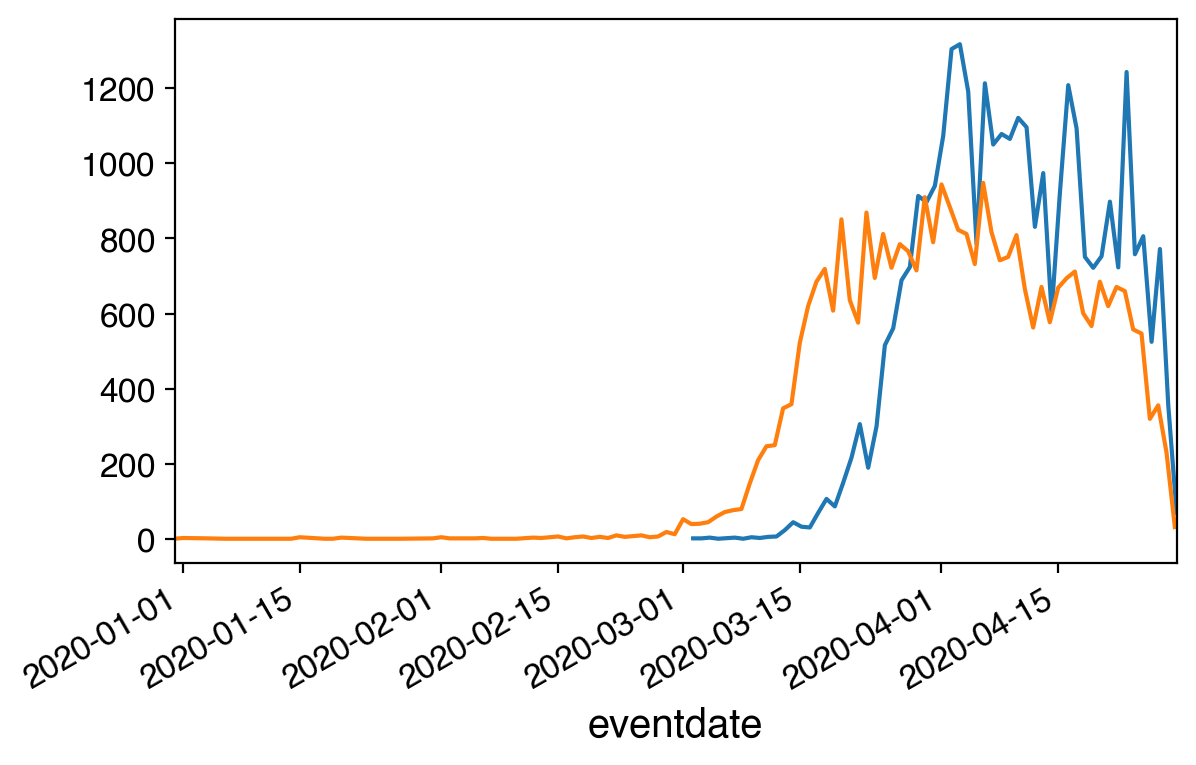

In [14]:
dfc.groupby("case")["gender"].count().plot()
dfc.groupby("eventdate")["gender"].count().plot()

In [15]:
# dfc.hospitalized.value_counts()

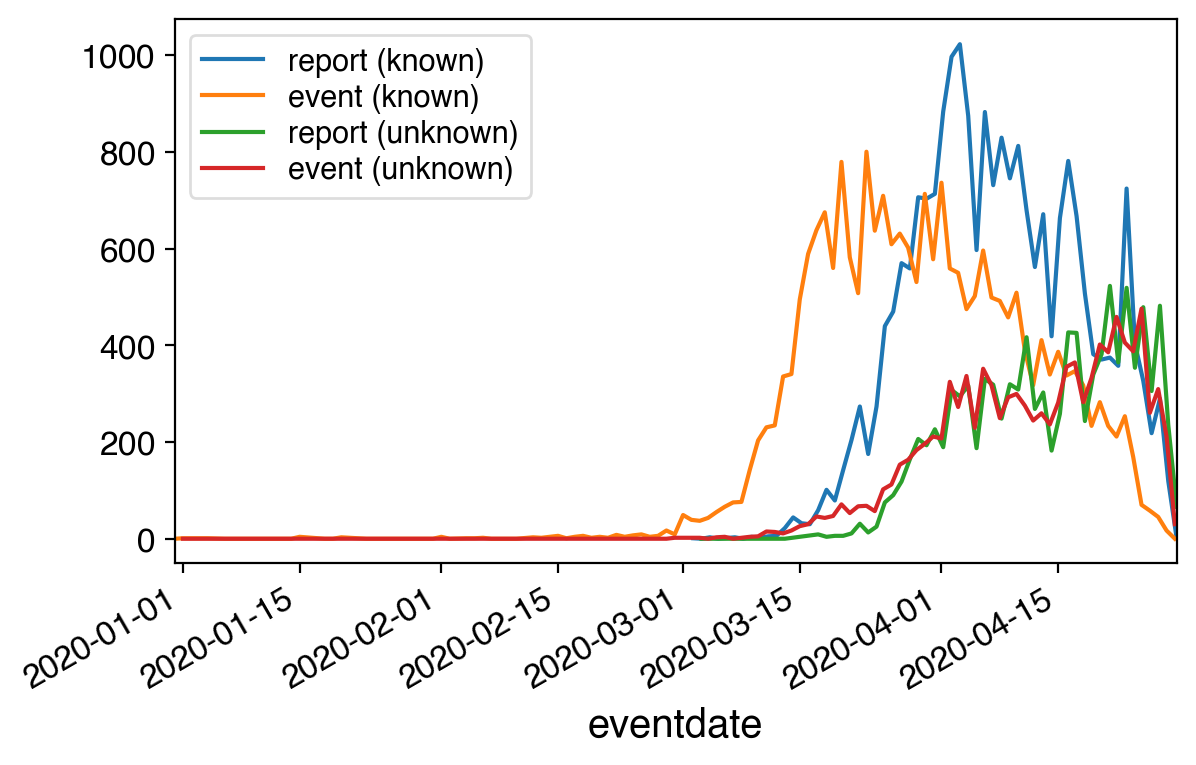

In [16]:
df = dfc.query("known_status")
df.groupby("case")["gender"].count().plot(label="report (known)")
df.groupby("eventdate")["gender"].count().plot(label="event (known)")

df = dfc.query("not known_status")
df.groupby("case")["gender"].count().plot(label="report (unknown)")
df.groupby("eventdate")["gender"].count().plot(label="event (unknown)")

plt.gca().legend()

In [17]:
dfc.sort_values("eventdate")

,age,case,died,eventdate,gender,hospitalized,known_status
23697,64,2020-04-17 05:00:00,False,2019-12-31,F,NO,True
31822,75,2020-04-26 05:00:00,False,2020-01-01,F,NO,True
30843,56,2020-04-25 05:00:00,False,2020-01-01,F,NO,True
15709,4,2020-04-08 05:00:00,False,2020-01-01,F,UNKNOWN,False
1875,56,2020-03-25 05:00:00,False,2020-01-04,F,NO,True
...,...,...,...,...,...,...,...
33160,72,2020-04-29 05:00:00,False,2020-04-29,F,UNKNOWN,False
33151,49,2020-04-29 05:00:00,False,2020-04-29,M,UNKNOWN,False
33152,44,2020-04-29 05:00:00,False,2020-04-29,F,UNKNOWN,False
33176,85,2020-04-29 05:00:00,False,2020-04-29,M,UNKNOWN,False


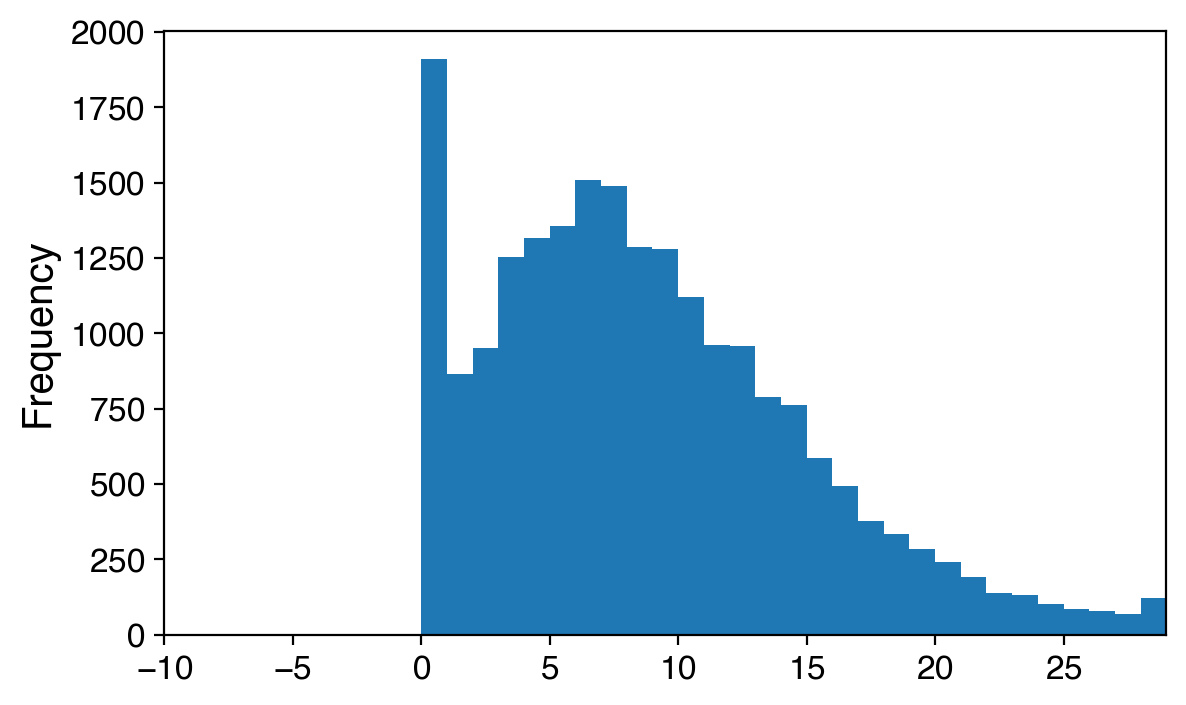

In [18]:
# df = dfc.query("died")
df = dfc.query("not died and known_status")
((df["case"]-df["eventdate"]).dt.days).plot.hist(bins=np.arange(-10,30))

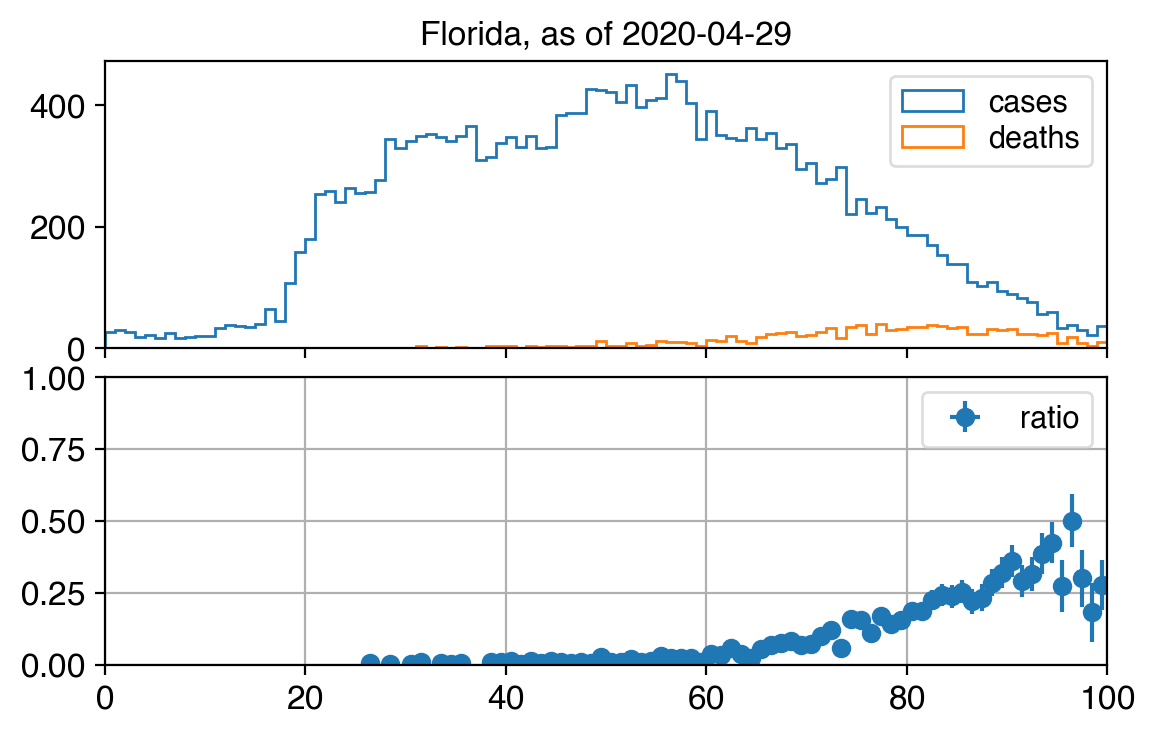

In [19]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

bins = "100,0,100"

# dfnumer = dfc.query("died")
dfnumer = dfc.query("died and known_status")
dfdenom = dfc.query("known_status")

hnumer = Hist1D(dfnumer["age"],bins=bins)
hdenom = Hist1D(dfdenom["age"],bins=bins)

hdenom.plot(ax=ax1, label="cases", histtype="step")
hnumer.plot(ax=ax1, label="deaths", histtype="step")

# ax1.set_yscale("log")

hratio = hnumer.divide(hdenom,binomial=True)
hratio.plot(ax=ax2, show_errors=True, label="ratio")

ax1.set_title(f"Florida, as of {str(dfc['case'].max()).split()[0]}")
ax2.set_ylim(bottom=0.,top=1.)
ax1.legend()
ax2.legend()
ax2.grid()

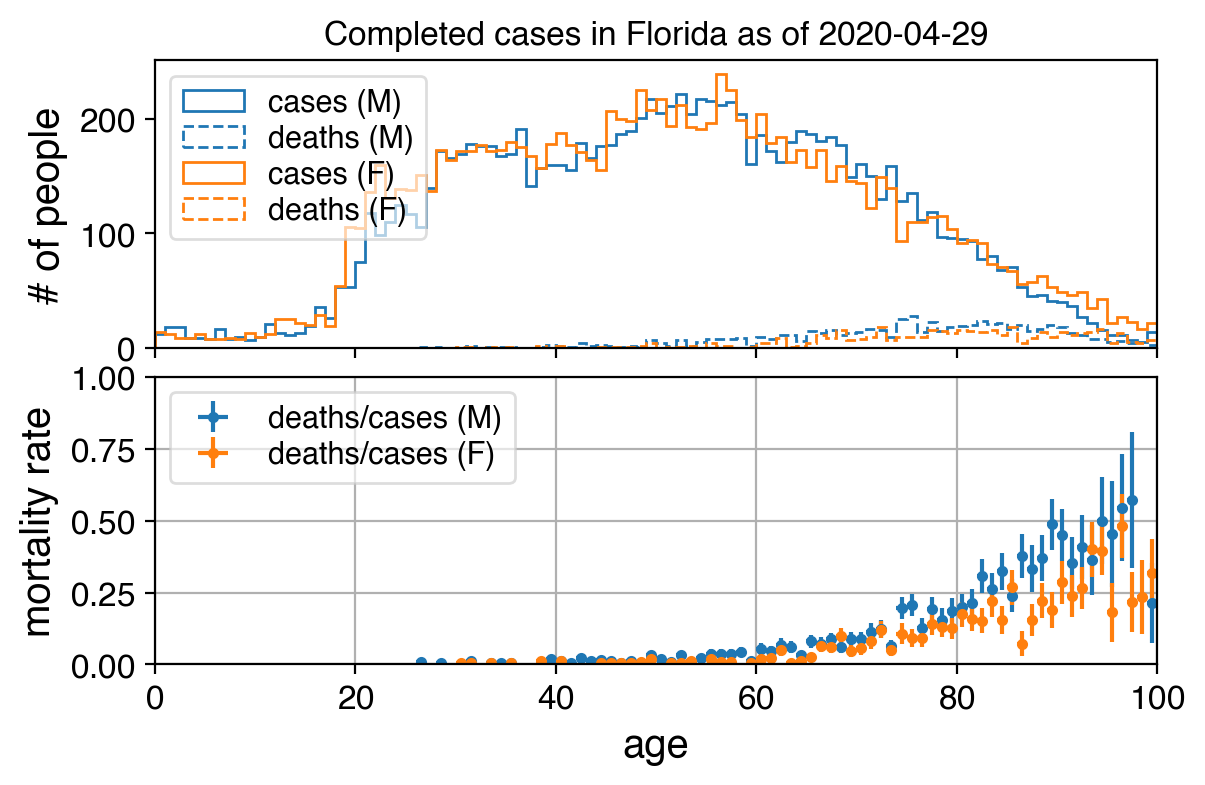

In [20]:

fig, (ax1,ax2) = plt.subplots(2,sharex=True)

def hists_gender(gender, bins="100,0,100", known=True):
    if gender in ["M","F"]:
        selstr = f"gender=='{gender}'"
    else:
        selstr = "gender!='X'"
    if known:
        selstr += " and known_status"
    dfnumer = dfc.query(selstr + " and died")
    dfdenom = dfc.query(selstr)
    hnumer = Hist1D(dfnumer["age"],bins=bins)
    hdenom = Hist1D(dfdenom["age"],bins=bins)
    hratio = hnumer.divide(hdenom,binomial=True)
    return hnumer, hdenom, hratio

hnumer, hdenom, hratio = hists_gender("M")
hdenom.plot(ax=ax1, label="cases (M)", histtype="step", color="C0")
hnumer.plot(ax=ax1, label="deaths (M)", histtype="step", color="C0", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M)", color="C0", ms=3)

hnumer, hdenom, hratio = hists_gender("F")
hdenom.plot(ax=ax1, label="cases (F)", histtype="step", color="C1")
hnumer.plot(ax=ax1, label="deaths (F)", histtype="step", color="C1", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F)", color="C1", ms=3)

# hnumer, hdenom, hratio = hists_gender("M", known=False)
# hdenom.plot(ax=ax1, label="cases (M), all", histtype="step", color="C2")
# hnumer.plot(ax=ax1, label="deaths (M), all", histtype="step", color="C2", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M), all", color="C2", ms=3)

# hnumer, hdenom, hratio = hists_gender("F", known=False)
# hdenom.plot(ax=ax1, label="cases (F), all", histtype="step", color="C3")
# hnumer.plot(ax=ax1, label="deaths (F), all", histtype="step", color="C3", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F), all", color="C3", ms=3)


last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

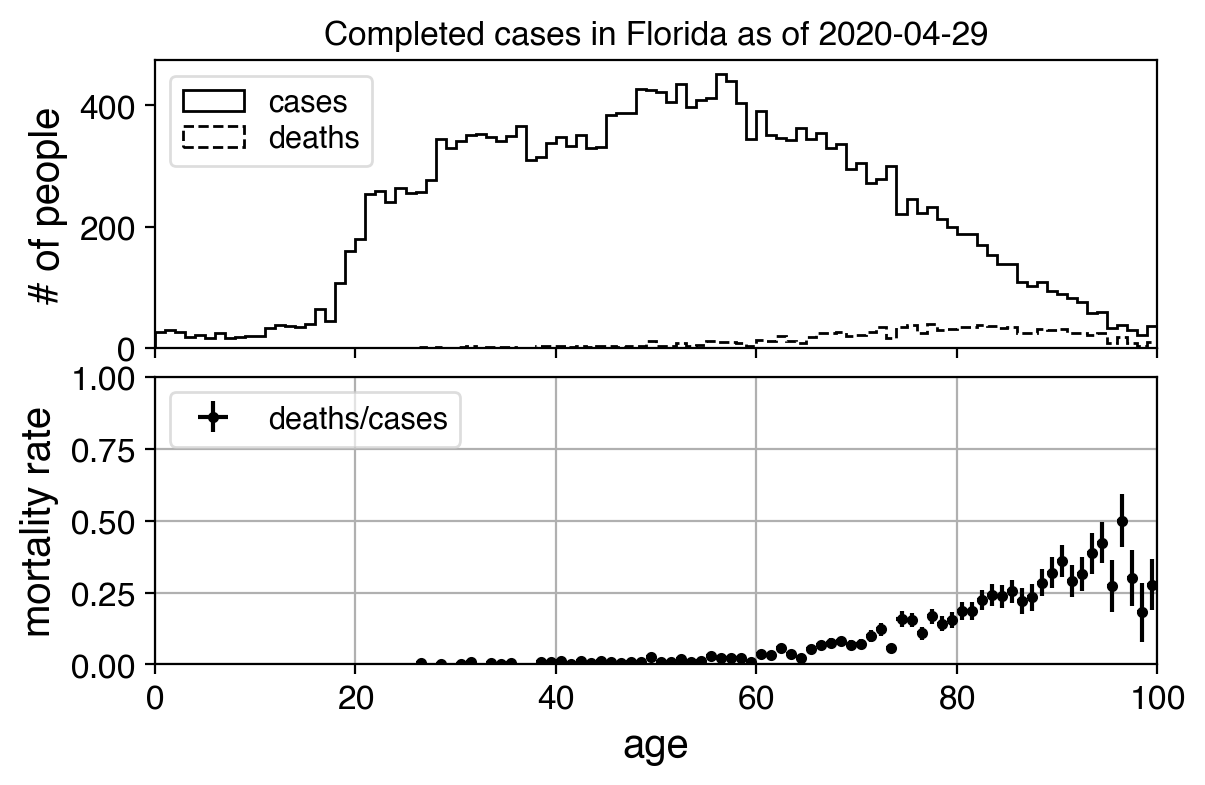

In [21]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

hnumer, hdenom, hratio = hists_gender("X", bins="100,0,100")
hdenom.plot(ax=ax1, label="cases", histtype="step", color="k")
hnumer.plot(ax=ax1, label="deaths", histtype="step", color="k", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases", color="k", ms=3)

last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

In [28]:
(hnumer.counts * hnumer.bin_centers).sum() / hnumer.counts.sum()

76.60272727272728

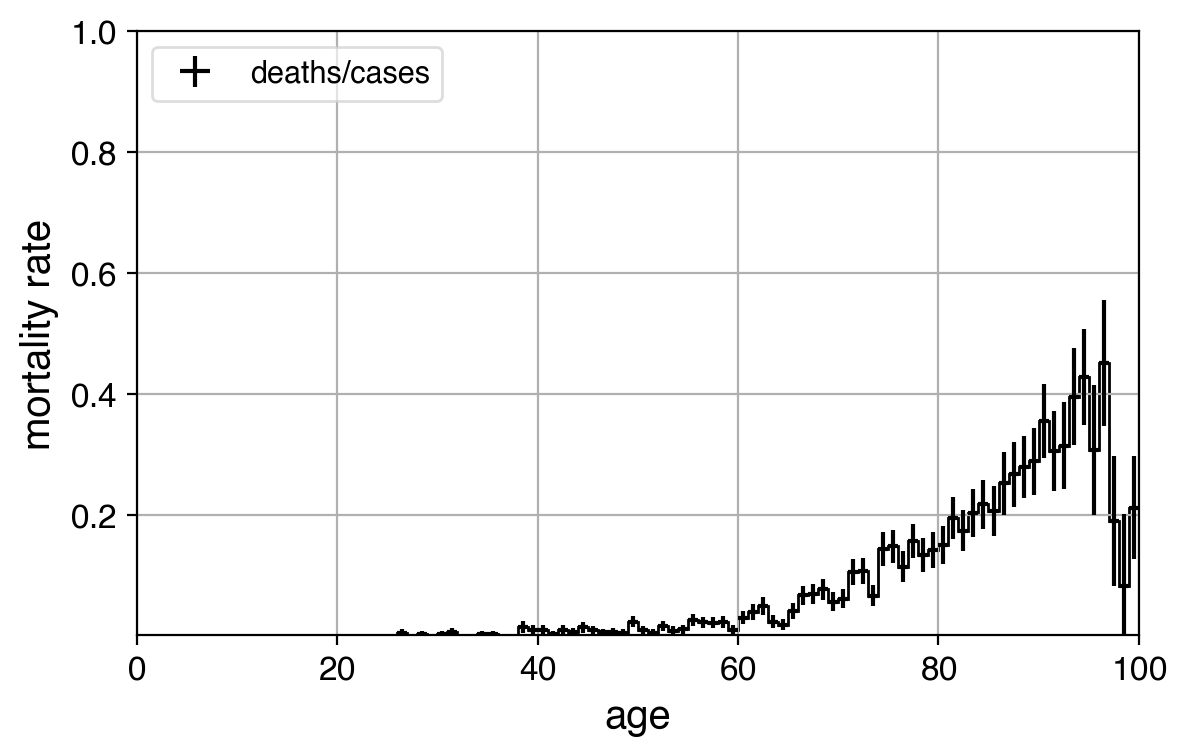

In [32]:
fig, ax = plt.subplots()

hratio = hists_gender("X")[-1]
hratio.plot(ax=ax, color="k", histtype="step")
hratio.plot(ax=ax, show_errors=True, label="deaths/cases", color="k", ms=0)

ax.legend(loc="upper left")
ax.set_ylabel("mortality rate")
ax.set_ylim(bottom=0.001,top=1.0)
# ax.set_yscale("log")
ax.set_xlabel("age")
ax.grid()

In [33]:
# bins = "25,0,100"
bins = "1,0,100"
mdr = hists_gender("M",bins=bins)[-1]
fdr = hists_gender("F",bins=bins)[-1]
# mdr.plot(show_errors=True)
# fdr.plot(show_errors=True)

mdr/fdr
# fig, ax = plt.subplots()
# (mdr/fdr).plot(ax=ax,show_errors=True)
# ax.set_ylim([0,2])

bin,content
"(0,100)",1.65648 ± 0.115198


In [29]:
mu = (mdr/fdr).counts[0]
err = (mdr/fdr).errors[0]
nsig = (mu-1)/err
print(nsig)

5.211203833244391


In [14]:
bins = np.linspace(0,100,11).astype(int)
pd.cut(np.clip(dfc["age"],0.1,99.9), bins=bins, right=False).value_counts().sort_index()

[0, 10)       110
[10, 20)      323
[20, 30)     2114
[30, 40)     2646
[40, 50)     2801
[50, 60)     3088
[60, 70)     2632
[70, 80)     1811
[80, 90)      899
[90, 100)     228
Name: age, dtype: int64

In [15]:
pd.cut(np.clip(dfc.query("died")["age"],0.1,99.9), bins=bins, right=False).value_counts().sort_index()

[0, 10)        0
[10, 20)       0
[20, 30)       1
[30, 40)       8
[40, 50)      16
[50, 60)      24
[60, 70)      54
[70, 80)     107
[80, 90)     112
[90, 100)     48
Name: age, dtype: int64

In [16]:
print(dfc["gender"].value_counts())
print(dfc.query("died")["gender"].value_counts())

M    8603
F    8049
Name: gender, dtype: int64
M    230
F    140
Name: gender, dtype: int64
